In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import time    
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
print(f"Torch version= {torch.__version__},\nCuda version={torch.version.cuda}")

Torch version= 1.12.1+cu116,
Cuda version=11.6


In [3]:
df = pd.read_csv("../data/data.csv", index_col="index", converters={#'valid_years_days_dict': eval, 
                                                 'valid_years_list':eval})
df.head()

,weekday_name,month,leap_year_condition,decade,output,output_year_digit,output_year,valid_years_days_dict,valid_years_list,valid_day_list,decade4,valid_group_days_index,century_code,month_code,year_code
index,,,,,,,,,,,,,,,
0,2,1,0,180,1-1-1800,0,1800,"{0: [1, 8, 15, 22, 29], 1: [7, 14, 21, 28], 2:...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,7,2,0,0
1,3,1,0,180,1-1-1801,1,1801,"{0: [2, 9, 16, 23, 30], 1: [1, 8, 15, 22, 29],...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,7,2,0,1
2,4,1,0,180,1-1-1802,2,1802,"{0: [3, 10, 17, 24, 31], 1: [2, 9, 16, 23, 30]...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,7,2,0,2
3,5,1,0,180,1-1-1803,3,1803,"{0: [4, 11, 18, 25], 1: [3, 10, 17, 24, 31], 2...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,7,2,0,3
4,6,1,1,180,1-1-1804,4,1804,"{4: [1, 8, 15, 22, 29], 8: [3, 10, 17, 24, 31]}","[4, 8, 4, 4, 4, 4, 4, 4]","[1, 8, 15, 22, 29]",0,7,2,0,5


**A- training for getting the year**

In [4]:
# fix random number generation aka regenerate the same random numbers every time (such as weight and bias initialization )
def set_random_seed(seed=7, deterministic=True):
    """Set random seed, for python, numpy, pytorch

    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for
            CUDNN backend, i.e., set `torch.backends.cudnn.deterministic`
            to True and `torch.backends.cudnn.benchmark` to False.
            Default: True.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False 
seed=7        
set_random_seed(seed=seed)

In [5]:
# output_year_digit column is just the last number in the output column
x_year = df[["leap_year_condition", "decade", "decade4", "valid_years_list", "output_year_digit"]]
y_year = x_year.pop("output_year_digit")
v = x_year.pop("valid_years_list")
v = pd.DataFrame([i for i in v])
# v.head(7), x_year.head(7)

In [6]:
# the previous cell code is replacement for this cell code, as i want to use the same train_test_split data, 
#so i willn't resplit the data again using train_test_split function


xtrain_year, xtest_year, ytrain_year, ytest_year, vtrain_year, vtest_year = train_test_split(x_year, 
                                                                                             y_year, 
                                                                                             v, 
                                                                                             test_size=0.19, 
                                                                                             shuffle=True, 
                                                                                             random_state=seed, 
                                                                                             stratify=df.valid_group_days_index)

In [7]:
# i save this two files as i will use these indices in train year_prediction model in the the other notebook
pd.DataFrame(xtrain_year.index).to_csv("../data/train_indices.csv", header=True, index=True)
pd.DataFrame(xtest_year.index).to_csv("../data/test_indices.csv", header=True, index=True)

In [8]:
class CollectedData(Dataset):
    def __init__(self, x, y, v):
        self.data = torch.tensor(x.values.astype(np.float32))
        self.label = torch.tensor(y.values)
        self.valids = torch.tensor(v.values.astype(np.int8))
        self.n_smpl = x.shape[0]
        
        
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx], self.valids[idx]
    
    def __len__(self):
        return self.n_smpl    

train_set_year = CollectedData(xtrain_year, ytrain_year, vtrain_year)
test_set_year = CollectedData(xtest_year, ytest_year, vtest_year)    

In [9]:
# #replacement for the previous cell
# # train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-int(len(dataset)*0.2), int(len(dataset)*0.2)])

# train_labels_year = torch.tensor(ytrain_year.values.astype(np.float32)) 
# test_labels_year = torch.tensor(ytest_year.values.astype(np.float32)) 
# train_input_year = torch.tensor(xtrain_year.values.astype(np.float32)) 
# test_input_year = torch.tensor(xtest_year.values.astype(np.float32)) 

# train_set_year = TensorDataset(train_input_year, train_labels_year)
# test_set_year = TensorDataset(test_input_year, test_labels_year)


In [12]:
# calculating accuracy
@torch.no_grad()
def calculate_accuracy(model, data_loader):
    model.eval()
    
    num_correct = 0
    num_samples = 0

    for data, labels, valids in data_loader:
        
        # transfering data to cuda
        data = data.to(device=device)
        valids = valids.to(device=device)
                
        preds = model(data)
        num_correct += len([1 for pred, vald in zip(preds.argmax(dim=1), valids) if pred in vald])
        num_samples += len(preds)
    accuracy = num_correct/num_samples
    model.train()
    return accuracy  

In [10]:
batch_size = 128

train_loader_year = DataLoader(dataset=train_set_year, shuffle=True, batch_size=batch_size)
test_loader_year = DataLoader(dataset=test_set_year, batch_size=batch_size) 

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class network(nn.Module):
    def __init__(self, in_features=3, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 20)
        self.fc2 = nn.Linear(20, 15)
        self.fc3 = nn.Linear(15, out_features) 
        self.initialize_weights()
        
        
    def forward(self, inpt):
        out = F.leaky_relu(self.fc1(inpt))
        out = F.leaky_relu(self.fc2(out))
        out = (self.fc3(out))
        return out
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

In [13]:
# initializing the network
model = network(in_features=3, out_features=10).to(device)
lr = 0.007
# loss and optimizer initializing
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=53, verbose=True)

In [14]:
num_epochs = 133

def train_model(num_epochs, data_loader=train_loader_year):
    num_batches = len(data_loader)
    print(f"starting learning rate = {lr} \n number of epochs = {num_epochs} \n number of batches = {num_batches} \n")
    # starting training loop epochs
    result_train_acc, result_test_acc = [], []
    for epoch in range(num_epochs):
        start_time = time.time()
        progress = tqdm(enumerate(data_loader), total=num_batches, leave=True)
        for batch_idx, (data, labels, valids) in progress: 

            # convert data to device
            data = data.to(device=device)
            labels = labels.to(device=device)
            # valids = valids.to(device=device)

            # getting prediction and loss
            preds = model(data)
            loss = criterion(preds, labels)        

            # back propagation
            optimizer.zero_grad()
            loss.backward()

            # optimization step
            optimizer.step()

            progress.set_description(f"epoch [{1+epoch}/{num_epochs}], loss={loss.item():0.4f}")
            progress.set_postfix()

        train_acc = calculate_accuracy(model, data_loader=train_loader_year)
        test_acc = calculate_accuracy(model, data_loader=test_loader_year)
        schedular.step(test_acc)
        print(f"after {1+epoch} epoch, train_acc = {(train_acc*100):.2f}%, test_acc = {(test_acc*100):.2f}%, time_elapsed = {((time.time()-start_time)/60):.1f} minuts")
        result_train_acc += [train_acc]
        result_test_acc += [test_acc]
        schedular.step(test_acc)        
        if train_acc==1.0 and test_acc==1.0:
            return result_train_acc, result_test_acc            
    return result_train_acc, result_test_acc
result_train_acc, result_test_acc = train_model(num_epochs, data_loader=train_loader_year) 


starting learning rate = 0.007 
 number of epochs = 133 
 number of batches = 927 



epoch [1/133], loss=2.2992: 100%|████████████████████████████████████████████████████| 927/927 [00:28<00:00, 33.07it/s]


after 1 epoch, train_acc = 45.79%, test_acc = 46.29%, time_elapsed = 1.3 minuts


epoch [2/133], loss=2.3108: 100%|████████████████████████████████████████████████████| 927/927 [00:10<00:00, 88.24it/s]


after 2 epoch, train_acc = 75.72%, test_acc = 75.92%, time_elapsed = 1.0 minuts


epoch [3/133], loss=2.3026: 100%|████████████████████████████████████████████████████| 927/927 [00:10<00:00, 87.03it/s]


after 3 epoch, train_acc = 45.79%, test_acc = 46.29%, time_elapsed = 1.0 minuts


epoch [4/133], loss=2.2602: 100%|████████████████████████████████████████████████████| 927/927 [00:10<00:00, 88.91it/s]


after 4 epoch, train_acc = 54.21%, test_acc = 53.71%, time_elapsed = 1.0 minuts


epoch [5/133], loss=2.1221: 100%|████████████████████████████████████████████████████| 927/927 [00:10<00:00, 91.54it/s]


after 5 epoch, train_acc = 90.03%, test_acc = 89.91%, time_elapsed = 1.0 minuts


epoch [6/133], loss=2.1330: 100%|████████████████████████████████████████████████████| 927/927 [00:10<00:00, 89.65it/s]


after 6 epoch, train_acc = 90.03%, test_acc = 89.91%, time_elapsed = 1.0 minuts


epoch [7/133], loss=2.0469: 100%|████████████████████████████████████████████████████| 927/927 [00:09<00:00, 92.92it/s]


after 7 epoch, train_acc = 94.01%, test_acc = 93.96%, time_elapsed = 1.0 minuts


epoch [8/133], loss=1.8476: 100%|████████████████████████████████████████████████████| 927/927 [00:10<00:00, 92.34it/s]


after 8 epoch, train_acc = 100.00%, test_acc = 100.00%, time_elapsed = 1.0 minuts


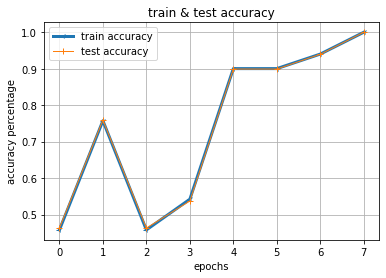

In [15]:
train_line_val = np.array([val for val in result_train_acc])# just replace val with val.cpu() if output is cuda
test_line_val = np.array([val for val in result_test_acc])# just replace val with val.cpu() if output is cuda

train_line, = plt.plot((range(len(train_line_val))), train_line_val, label="train accuracy", marker="x", linewidth=3)
test_line, = plt.plot((range(len(test_line_val))), test_line_val, label="test accuracy", marker="+", linewidth=1.5)
plt.legend(loc="best", handles=[train_line, test_line])
plt.title("train & test accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy percentage")
plt.grid()
plt.show()

In [16]:
r_test = xtest_year 
dt = r_test.copy(deep=True) 
r_test = torch.tensor(dt.values.astype(np.float32)).to(device=device)
dt["predicted_year_digit"] = model(r_test).argmax(dim=1).cpu()
dt["predicted_year"] = [str(dec+pred) for dec, pred in zip(dt.decade*10, dt.predicted_year_digit)]
dt.head()

,leap_year_condition,decade,decade4,predicted_year_digit,predicted_year
index,,,,,
19729,1,188,0,4,1884
18483,0,183,1,3,1833
103614,1,195,1,2,1952
8841,0,181,1,3,1813
97054,1,181,1,2,1812


In [17]:
test_accuracy = calculate_accuracy(model, data_loader=test_loader_year)
print(f"test_accuracy = {test_accuracy*100}%")

test_accuracy = 100.0%


**i got accuracy of 90.20% when i used just two columns(decade_year_condition, and decade)**

In [18]:
# torch.save(model, "../data/year_model_saved")
# model = torch.load("../data/year_model_saved")

In [19]:
# dt.to_csv("../data/year_predictions.csv", header=True, index=True)